# Modeling
I will start by running my data through some Naive Bayes models, Logistic Regression, Random Forest and Ada Boost. In this notebook I will leave the stopwords to the english dictionary, based on my [EDA](./2_eda_%26_cleaning.ipynb), there weren't any identifiable words that made it in the categories' top 25 words. I will only run the lyrics column through the models with the target being the skip column.



#### Table of Contents
<br>`Pre-Processing`</br>

- [Baseline & Target](#target)
- [Pipeline & GridSearch Function](#func)

<br>`Modeling`</br>

- [MultinomialNB](#Mnb)
- [BernoulliNB](#Bnb)
- [Logistic Regression](#Lg)
- [Ada Boost](#ada)
- [Random Forest](#forest)

<br>`Conclusion`</br>

- [Feat Importance of Best Model](#feat)
- [Notebook Conclusion](#conc)    

### Libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text # to add more stopwords

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, f1_score, recall_score

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

In [2]:
df = pd.read_csv('./data/lyrics_cleaned.csv')

### Baseline<a id='target'></a>  
Because my class in so imbalanced I will not be using accuracy as my score, instead I will be looking at variations of F1 score, confusion matrix, and precision score which are all ideal for imbalanced classes. The reason accuracy is not ideal is because accuracy will always predict on the heavier class when imbalanced.

In [3]:
df["skip"].value_counts(normalize=True) #Baseline

0    0.75993
1    0.24007
Name: skip, dtype: float64

There are some words that I don't want displayed on screen so I will replace them as 'vulgar', they can still help my model with it's predictions. These words are not so much easy predictors, as much as they are words that I don't feel comfortable being part of my visualizations or my publicly viewable project.

In [4]:
some_words = open("./data/drop_words.txt").read().split()

for i in some_words:   
    df['lyrics'] = df['lyrics'].str.lower().str.replace(rf"\b{i}\b", 'vulgar')

### Train Test Split
As mentioned earlier, I will use the lyrics column in my models with my target being the skip column. All other columns were made for EDA purposes.

In [5]:
X = df['lyrics']
y = df['skip']

In [6]:
# since the categories are unbalanced I will stratify y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y) 
# Check shapes of the split
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8591,), (2864,), (8591,), (2864,))

### Pipeline Function<a id='func'></a>  
I am re-using the pipeline function I made for my Reddit project NLP. Which allows me to put in various models and Vectorizer and returns scores along with confusion matrices.

In [7]:
def start_pipeline(vect, model, color, pipe_params): # takes type of vectorizer, model, color of confusion matrix, and pipe params
    
    # Types of Vectorizers
    if vect == 'cv':
        instantiate_vect = CountVectorizer
        vect_name = 'CountVectorizer'
    elif vect == 'tvec':
        instantiate_vect = TfidfVectorizer
        vect_name = 'TfidfVectorizer'
        
      # Types of Models  
    if model == 'Mnb':
        instantiate_model = MultinomialNB
        model_name = 'MultinomialNB'
    elif model == 'Bnb':
        instantiate_model = BernoulliNB
        model_name = 'BernoulliNB'
    elif model == 'lg':
        instantiate_model = LogisticRegression
        model_name = 'LogisticRegression'
    elif model == 'ada':
        instantiate_model = AdaBoostClassifier
        model_name = 'AdaBoostClassifier'     
    elif model == 'rdf':
        instantiate_model = RandomForestClassifier
        model_name = 'RandomForestClassifier'
          
        
        #----- Pipeline-----#
    
    pipe = Pipeline([
    (vect , instantiate_vect(stop_words = 'english')), # transformer
    (model , instantiate_model()) # estimator
    ])

    # --- Gridsearch----#
    gs = GridSearchCV(pipe,
                 pipe_params, # defined outside of function for easy change
                 cv=5,
                 verbose = 1,
                 n_jobs=-1)
    
    
    gs.fit(X_train,y_train) # fitting X_train and y_train
    preds = gs.predict(X_test) # predict test
    train_preds = gs.predict(X_train) # predict train
    
    #------ Scores & Params------- #
    print(f'Gridsearch best score is: {gs.best_score_}')
    print('')
    print(f'Gridsearch best params are: {gs.best_params_}')
    print('')
    print(f'{model_name} with {vect_name} Train Score :  {gs.score(X_train, y_train)*100:.2f}%')
    print(f'{model_name} with {vect_name}  Test Score  : {gs.score(X_test, y_test)*100:.2f}%')
    print('')
    print(f'{model_name} with {vect_name}  F1- Train Score: {f1_score(y_train, train_preds)}')
    print(f'{model_name} with {vect_name}  F1- Test Score:  {f1_score(y_test, preds)}')
    print('')
    
     # ----- Predictions ------ #
        
    print(f"{(precision_score(y_test, preds))*100:.2f}% of the words were predicted correctly by the model.")
    print(f"{(recall_score(y_test, preds))*100:.2f}% of the Skipped songs were found.")

    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    print(f"The specificity is: {(tn / (tn + fp))*100:.2f}%")
    
    plot_confusion_matrix(gs, X_test, y_test, cmap= color);

### Multinomial Naive Bayes with Count Vectorizer<a id='Mnb'></a>  

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  2.5min finished


Gridsearch best score is: 0.7893135069865591

Gridsearch best params are: {'cv__max_df': 0.5, 'cv__max_features': 5000, 'cv__min_df': 2, 'cv__ngram_range': (1, 1)}

MultinomialNB with CountVectorizer Train Score :  81.74%
MultinomialNB with CountVectorizer  Test Score  : 79.05%

MultinomialNB with CountVectorizer  F1- Train Score: 0.6524916943521596
MultinomialNB with CountVectorizer  F1- Test Score:  0.6057818659658343

55.28% of the words were predicted correctly by the model.
67.01% of the Skipped songs were found.
The specificity is: 82.86%


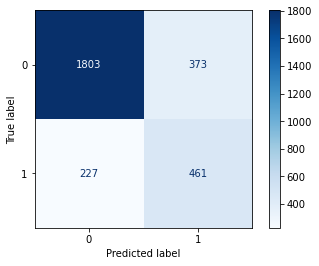

In [8]:
start_pipeline('cv', 'Mnb', 'Blues', pipe_params = {
                                'cv__max_features': [2_000, 4_500, 5_000, 5_500],
                                'cv__min_df' : [2,3], # ignore terms that show up less than 2 or 3 times in corpus
                                'cv__max_df' : [.5, .95], # ignore terms that show up either more than 50% or 95% of the corpus
                                'cv__ngram_range' : [(1,1), (1,2), (1,3)], # single words and bigrams
})

Slightly overfit with low precision score, F1 scores are above the .50 that we aim for but could be better

### Multinomial Naive Bayes with TFIDF Vectorizer

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  2.5min finished


Gridsearch best score is: 0.8072407882591403

Gridsearch best params are: {'tvec__max_df': 0.5, 'tvec__max_features': 6000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 3)}

MultinomialNB with TfidfVectorizer Train Score :  83.03%
MultinomialNB with TfidfVectorizer  Test Score  : 80.31%

MultinomialNB with TfidfVectorizer  F1- Train Score: 0.6130573248407644
MultinomialNB with TfidfVectorizer  F1- Test Score:  0.5451612903225806

61.23% of the words were predicted correctly by the model.
49.13% of the Skipped songs were found.
The specificity is: 90.17%


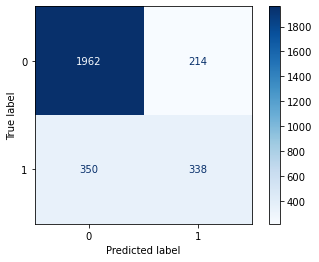

In [9]:

start_pipeline('tvec', 'Mnb', 'Blues', pipe_params = {
                                                        'tvec__max_features': [4_000, 5_000, 6_000, 7_000],
                                                        'tvec__ngram_range': [(1,1), (1,2), (1,3)],
                                                        'tvec__min_df' : [2,3], 
                                                        'tvec__max_df' : [.5, .95]})

Better precision score, however still overfit with F1 scores being further apart than before

### Bernoulli Naive Bayes with Count Vectorizer<a id='Bnb'></a>  

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 12.4min finished


Gridsearch best score is: 0.7968808516200163

Gridsearch best params are: {'Bnb__alpha': 0.275, 'cv__max_df': 0.5, 'cv__max_features': 9000, 'cv__min_df': 3, 'cv__ngram_range': (1, 2)}

BernoulliNB with CountVectorizer Train Score :  80.36%
BernoulliNB with CountVectorizer  Test Score  : 80.13%

BernoulliNB with CountVectorizer  F1- Train Score: 0.6552217453505007
BernoulliNB with CountVectorizer  F1- Test Score:  0.6524129505192425

56.27% of the words were predicted correctly by the model.
77.62% of the Skipped songs were found.
The specificity is: 80.93%


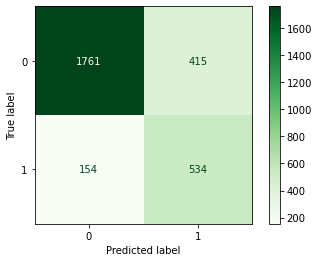

In [10]:
start_pipeline('cv', 'Bnb', 'Greens', pipe_params = {
                                                    'Bnb__alpha' : np.linspace(0.2,0.5,5),
                                                    'cv__max_features': [5_000, 5_500, 7_000, 9_000],
                                                    'cv__min_df' : [2,3],
                                                    'cv__max_df' : [.5, .95],
                                                    'cv__ngram_range' : [(1,1), (1,2), (1,3)]})

Scores are good, but still low on the precision score

### Bernoulli Naive Bayes with TFIDF Vectorizer

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 12.2min finished


Gridsearch best score is: 0.7958330539793217

Gridsearch best params are: {'Bnb__alpha': 0.425, 'tvec__max_df': 0.5, 'tvec__max_features': 7000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}

BernoulliNB with TfidfVectorizer Train Score :  80.24%
BernoulliNB with TfidfVectorizer  Test Score  : 80.24%

BernoulliNB with TfidfVectorizer  F1- Train Score: 0.654034229828851
BernoulliNB with TfidfVectorizer  F1- Test Score:  0.652760736196319

56.48% of the words were predicted correctly by the model.
77.33% of the Skipped songs were found.
The specificity is: 81.16%


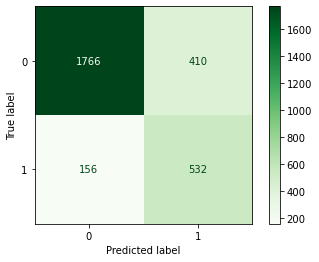

In [11]:
start_pipeline('tvec', 'Bnb', 'Greens', pipe_params = {
                                                'Bnb__alpha' : np.linspace(0.2,0.5,5),
                                                'tvec__max_features': [4_000, 5_000, 6_000, 7_000],
                                                'tvec__ngram_range': [(1,1), (1,2), (1,3)],
                                                'tvec__min_df' : [2,3], 
                                                'tvec__max_df' : [.5, .95],
})

Slightly higher than above on the precision, still alot of misclassified lyrics

### Logistic Regressions with Count Vectorizer<a id='Lg'></a>  

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 11.8min finished


Gridsearch best score is: 0.8121274179359498

Gridsearch best params are: {'cv__max_df': 0.5, 'cv__max_features': 9000, 'cv__min_df': 2, 'cv__ngram_range': (1, 1), 'lg__C': 0.5, 'lg__max_iter': 5000, 'lg__penalty': 'l2'}

LogisticRegression with CountVectorizer Train Score :  99.74%
LogisticRegression with CountVectorizer  Test Score  : 81.91%

LogisticRegression with CountVectorizer  F1- Train Score: 0.9946367625548512
LogisticRegression with CountVectorizer  F1- Test Score:  0.6213450292397661

62.50% of the words were predicted correctly by the model.
61.77% of the Skipped songs were found.
The specificity is: 88.28%


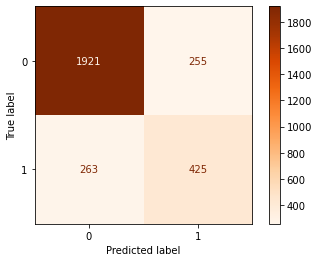

In [12]:
start_pipeline('cv', 'lg', 'Oranges', pipe_params = {'cv__max_features': [5_000, 5_500, 9_000],
                                         'cv__min_df' : [2,3],
                                         'cv__max_df' : [.5, .95],
                                         'cv__ngram_range' : [(1,1), (1,2), (1,3)],
                                         'lg__penalty' : ['l1', 'l2'],
                                         'lg__C' : [0.5,1.0,2.5],
                                         'lg__max_iter' : [5000]})


Way overfit

### Logistic Regressions with TFIDF Vectorizer

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 10.0min finished


Gridsearch best score is: 0.8203931137373776

Gridsearch best params are: {'lg__C': 2.5, 'lg__max_iter': 5000, 'lg__penalty': 'l2', 'tvec__max_df': 0.5, 'tvec__max_features': 5000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}

LogisticRegression with TfidfVectorizer Train Score :  89.21%
LogisticRegression with TfidfVectorizer  Test Score  : 81.98%

LogisticRegression with TfidfVectorizer  F1- Train Score: 0.7385049365303245
LogisticRegression with TfidfVectorizer  F1- Test Score:  0.5641891891891891

67.34% of the words were predicted correctly by the model.
48.55% of the Skipped songs were found.
The specificity is: 92.56%


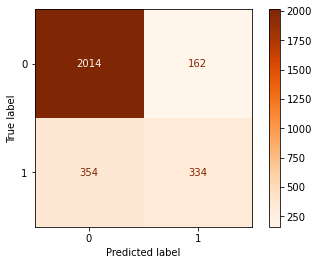

In [13]:
start_pipeline('tvec', 'lg', 'Oranges', pipe_params = {'tvec__max_features': [5_000, 5_500, 9_000],
                                            'tvec__min_df' : [2,3],
                                            'tvec__max_df' : [.5, .95],
                                            'tvec__ngram_range' : [(1,1), (1,2), (1,3)],
                                            'lg__penalty' : ['l1', 'l2'],
                                            'lg__C' : [0.5,1.0,2.5],
                                            'lg__max_iter' : [5000]})

Slightly better but not by much

### Ada Boost with Count Vectorizer<a id='ada'></a>  

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Gridsearch best score is: 0.8806880709403428

Gridsearch best params are: {'cv__max_df': 0.95, 'cv__max_features': 9000, 'cv__min_df': 2, 'cv__ngram_range': (1, 1)}

AdaBoostClassifier with CountVectorizer Train Score :  89.24%
AdaBoostClassifier with CountVectorizer  Test Score  : 88.58%

AdaBoostClassifier with CountVectorizer  F1- Train Score: 0.7451737451737451
AdaBoostClassifier with CountVectorizer  F1- Test Score:  0.7295285359801488

84.64% of the words were predicted correctly by the model.
64.10% of the Skipped songs were found.
The specificity is: 96.32%


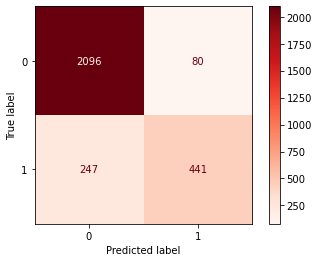

In [14]:
start_pipeline('cv', 'ada', 'Reds', pipe_params = {'cv__max_features': [5_000, 5_500, 9_000],
                                           'cv__min_df' : [2,3],
                                           'cv__max_df' : [.5, .95],
                                           'cv__ngram_range' : [(1,1), (1,2), (1,3)]})

That's more like it! 

### Ada Boost with TFIDF Vectorizer

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.0min finished


Gridsearch best score is: 0.8745199343636587

Gridsearch best params are: {'tvec__max_df': 0.95, 'tvec__max_features': 9000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 3)}

AdaBoostClassifier with TfidfVectorizer Train Score :  88.70%
AdaBoostClassifier with TfidfVectorizer  Test Score  : 88.51%

AdaBoostClassifier with TfidfVectorizer  F1- Train Score: 0.7313969571230982
AdaBoostClassifier with TfidfVectorizer  F1- Test Score:  0.7287716405605936

84.19% of the words were predicted correctly by the model.
64.24% of the Skipped songs were found.
The specificity is: 96.19%


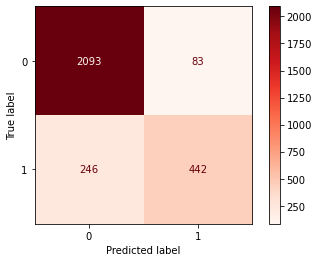

In [15]:
start_pipeline('tvec', 'ada', 'Reds', pipe_params = {'tvec__max_features': [5_000, 5_500, 9_000],
                                           'tvec__min_df' : [2,3],
                                           'tvec__max_df' : [.5, .95],
                                           'tvec__ngram_range' : [(1,1), (1,2), (1,3)]})

Precision a little lower than the countvectorized Ada Boost Model, however the F1 scores and train/test scores are much closer to eachother on this one.  

### Random Forest with Count Vectorizer<a id='forest'></a>  
I know I'm doing this in the wrong order, should be the Trees first then the boosters, but I got such good scores with the Ada Boost, I wanted to see how the Random Forest will do. Especially since the trees do well with unbalanced classes

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 29.4min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 38.4min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 49.0min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 60.4min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed: 72.1min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed: 86.4min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed: 103.7min
[Parallel(n_jobs=-1)]: Done 9720 out of 9720 | elapsed: 140.9min finished


Gridsearch best score is: 0.8454197116253935

Gridsearch best params are: {'cv__max_df': 0.5, 'cv__max_features': 5000, 'cv__min_df': 2, 'cv__ngram_range': (1, 2), 'rdf__max_depth': None, 'rdf__min_samples_split': 14, 'rdf__n_estimators': 200}

RandomForestClassifier with CountVectorizer Train Score :  98.94%
RandomForestClassifier with CountVectorizer  Test Score  : 85.30%

RandomForestClassifier with CountVectorizer  F1- Train Score: 0.9774361517480784
RandomForestClassifier with CountVectorizer  F1- Test Score:  0.6251113089937667

80.69% of the words were predicted correctly by the model.
51.02% of the Skipped songs were found.
The specificity is: 96.14%


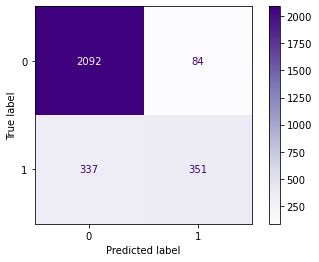

In [16]:
start_pipeline('cv', 'rdf', 'Purples', pipe_params = {'cv__max_features': [5_000, 5_500, 9_000],
                                           'cv__min_df' : [2,3],
                                           'cv__max_df' : [.5, .95],
                                           'cv__ngram_range' : [(1,1), (1,2), (1,3)],
                                            'rdf__min_samples_split': [14, 15, 16],
                                            'rdf__n_estimators': [100, 150, 200],
                                            'rdf__max_depth': [None, 1, 2, 3, 4, 5]})

Way Overfit

### Random Forest with TFIDF Vectorizer

In [ ]:
start_pipeline('tvec', 'rdf', 'Purples', pipe_params = {'tvec__max_features': [5_000, 5_500, 9_000],
                                           'tvec__min_df' : [2,3],
                                           'tvec__max_df' : [.5, .95],
                                           'tvec__ngram_range' : [(1,1), (1,2), (1,3)],
                                           'rdf__min_samples_split': [14, 15, 16],
                                           'rdf__n_estimators': [100, 150, 200],
                                            'rdf__max_depth': [None, 1, 2, 3, 4, 5]})

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  8.9min


Glad I jumped to Ada Boost

### Extracting Word Importance<a id='feat'></a>
Again using a function I created in my Reddit NLP I will extract word importance in my best scoring model (Ada Boost with TFIDF Vectorizer).

In [ ]:
def word_importance(model, vect, num): # takes model, vectorizer, and number of features
    skip_sorted = model.feature_log_prob_[1, :].argsort()[::-1] # getting the log probability of the feature [::-1] gives top features
    noskip_sorted = model.feature_log_prob_[0, :].argsort()[::-1]

    skip = np.take(vect.get_feature_names(), skip_sorted[:num])
    noskip = np.take(vect.get_feature_names(), noskip_sorted[:num]) # takes element from array, along axis, returns with feature_name

#Code addapted from:    
#https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes/50530697#50530697
#user piman314    

    print(f' Words in common in both classes : {np.intersect1d(skip, noskipo)}') #print a list where both words are in both arrays
    print('')
    
    skip_feat = pd.DataFrame((list(zip(skip, skip_sorted))),columns = ['Features', 'Importance'])
    noskip_feat = pd.DataFrame((list(zip(noskip, noskip_sorted))),columns = ['Features', 'Importance'])
    
    ### Graph of skipTheAsshole Feature Importance

    
    skip_feat.set_index(skip_feat.Features, inplace=True) # so y label shows right

    skip_unit = skip_feat[:num].sort_values('Importance', ascending=False)['Importance'] # sort by coefficient show top 5
    color = ['#DF6120' if i > 5000 else "#40668C" for i in skip_unit]

    labels = skip_unit.index #only labels of selected

    plt.figure(figsize=(25,12))
    plt.barh(labels, skip_unit, color = color)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.xlabel('Feature Importance', fontsize=30)
    plt.title(f'Top {num} Predictable Words to Skipped Songs', fontsize=42, color ='#FF4500', weight='bold')
    if vect == cv:
        plt.savefig(f'./visuals/skip_pred_words_cv.png', transparent=True, bbox_inches='tight')
    else:    
        plt.savefig(f'./visuals/skip_pred_words_tfid.png', transparent=True, bbox_inches='tight')

    
    ### Graph of noskipOMIL Feature Importance

    noskip_feat.set_index(noskip_feat.Features, inplace=True) # so y label shows right

    noskip_unit = noskip_feat[:num].sort_values('Importance', ascending=False)['Importance'] # sort by coefficient show top 5
    color = ['#DF6120' if i > 5000 else "#40668C" for i in noskip_unit]

    labels = noskip_unit.index #only labels of selected

    plt.figure(figsize=(25,12))
    plt.barh(labels, noskip_unit, color = color)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.xlabel('Feature Importance', fontsize=30)
    plt.title(f'Top {num} Predictable Words to Not Skipped Songs', fontsize=42, color ='#FF4500', weight='bold')
    if vect == cv:
        plt.savefig('./visuals/noskip_pred_words_cv.png', transparent=True, bbox_inches='tight')
    else:    
        plt.savefig('./visuals/noskip_pred_words_tfid.png', transparent=True, bbox_inches='tight')

### Conclusion<a id='conc'></a>
Of all my models here, the AdaBoost with TFIDF Vectorizer did the best. With a precision score of 84.19%, speicificity at 96.19% and the train test scores in both the model score and F1 score being minimally apart, showing little sign of overfitting.
The best params being tri-grams and max_features at 9000. To note I did add some options in the pipe params for AdaBoost, but it performed better with its standard settings.

<b> What's next? </b>
I'd like to rerun these models with a Word Lemmatizer in the [next notebook](./4.1_Model_Word_Lem.ipynb) to see if it will help my model's predictions be more precise, after that I will look into Regularization Neural Networks and possible play with some SVM. 
<br> Depending on what happens with the next set of models I might consider doing some resampling to help with the class imbalance, however with the way the scores are going so far, especially with the AdaBoost score, it might not be needed.</br>